# Overvew
- nb020の改良
- SpectrogramEventRmsDatasetV4(nb021)を使用する
- 1秒の推論を行なうモデル

# CONST

In [32]:
NB = '022'
DEBUG = False
PATH_EVENT = './../data_ignore/event/nb017_event_rms/nb017_event_rms.csv'
DATASET = '32khz'
DIR_MODEL = './../data_ignore/model'

In [33]:
settings_str = """
globals:
  seed: 1213
  device: cuda
  num_epochs: 45
  output_dir: /kaggle/training_output/
  use_fold: 0
  target_sr: 32000

dataset:
  name: SpectrogramDataset
  params:
    img_size: 224
    melspectrogram_parameters:
      n_mels: 128
      fmin: 20
      fmax: 16000
    
split:
  name: StratifiedKFold
  params:
    n_splits: 5
    random_state: 42
    shuffle: True

loader:
  train:
    batch_size: 20
    shuffle: True
    num_workers: 5
    pin_memory: True
    drop_last: True
  val:
    batch_size: 15
    shuffle: False
    num_workers: 5
    pin_memory: True
    drop_last: False

model:
  name: resnest50_fast_1s1x64d
  params:
    pretrained: True
    n_classes: 264

loss:
  name: BCEWithLogitsLoss
  params: {}

optimizer:
  name: Adam
  params:
    lr: 0.001

scheduler:
  name: CosineAnnealingLR
  params:
    T_max: 10
"""

# Import everything I need :)

In [34]:
import os
import gc
import cv2 
import time
import yaml
import random
import librosa
import numpy as np
import pandas as pd
import soundfile as sf
from pathlib import Path
from scipy.io import wavfile
import matplotlib.pyplot as plt
from fastprogress import progress_bar
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
from torchvision import models
import torch.utils.data as data

import sys
sys.path.insert(0, './../src/util/')
from const import BIRD_CODE, INV_BIRD_CODE

# My function

In [35]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore

In [36]:
def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

In [37]:
def train(model, device, train_loader, optimizer, scheduler, loss_func):
    model.train()
    epoch_train_loss = 0
    for batch_idx, (data, target) in enumerate(progress_bar(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_train_loss += loss.item()*data.size(0)
    loss = epoch_train_loss / len(train_loader.dataset)
    del data
    return loss

class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.
    https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
    """
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        self.best_state_dict = {}
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
#         torch.save(model.state_dict(), self.path)
        self.best_state_dict = model.state_dict()
        self.val_loss_min = val_loss
        
def get_epoch_loss(model, device, valid_loder, loss_func):
    model.eval()
    epoch_valid_loss = 0
    for batch_idx, (data, target) in enumerate(progress_bar(valid_loader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = loss_func(output, target)
        epoch_valid_loss += loss.item()*data.size(0)
    
    loss = epoch_valid_loss / len(valid_loader.dataset)
    del data
    return loss

def evaluate(model, device, valid_loder, loss_func):
    model.eval()
    epoch_valid_loss = 0
    for batch_idx, (data, target) in enumerate(progress_bar(valid_loader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, preds = torch.max(outputs, 1)
        loss = loss_func(output, target)
        epoch_valid_loss += loss.item()*data.size(0)
    
    loss = epoch_valid_loss / len(valid_loader.dataset)
    del data
    return loss

In [38]:
class SpectrogramDataset(data.Dataset):
    def __init__(self, file_list, img_size=224, 
                 waveform_transforms=None, spectrogram_transforms=None, melspectrogram_parameters={}):
        
        self.file_list = file_list  # list of list: [file_path, ebird_code]
        self.img_size = img_size
        self.waveform_transforms = waveform_transforms
        self.spectrogram_transforms = spectrogram_transforms
        self.melspectrogram_parameters = melspectrogram_parameters

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx: int):
        wav_path, ebird_code = self.file_list[idx]

        y, sr = sf.read(wav_path)
#         sr, y = wavfile.read(wav_path)

        if self.waveform_transforms:
            y = self.waveform_transforms(y)
        else:
            len_y = len(y)
            effective_length = sr * PERIOD
            if len_y < effective_length:
                new_y = np.zeros(effective_length, dtype=y.dtype)
                start = np.random.randint(effective_length - len_y)
                new_y[start:start + len_y] = y
                y = new_y.astype(np.float32)
            elif len_y > effective_length:
                start = np.random.randint(len_y - effective_length)
                y = y[start:start + effective_length].astype(np.float32)
            else:
                y = y.astype(np.float32)

        melspec = librosa.feature.melspectrogram(y, sr=sr, **self.melspectrogram_parameters)
        melspec = librosa.power_to_db(melspec).astype(np.float32)

        if self.spectrogram_transforms:
            melspec = self.spectrogram_transforms(melspec)
        else:
            pass

        image = mono_to_color(melspec)
        height, width, _ = image.shape
        image = cv2.resize(image, (int(width * self.img_size / height), self.img_size))
        image = np.moveaxis(image, 2, 0)
        image = (image / 255.0).astype(np.float32)

#         labels = np.zeros(len(BIRD_CODE), dtype="i")
        labels = np.zeros(len(BIRD_CODE), dtype="f")
        labels[BIRD_CODE[ebird_code]] = 1

        return image, labels

class SpectrogramEventRmsDataset(data.Dataset):
    def __init__(self, file_list, img_size=224, 
                 waveform_transforms=None, spectrogram_transforms=None, melspectrogram_parameters={}):
        
        self.file_list = file_list  # list of list: [file_path, ebird_code]
        self.img_size = img_size
        self.waveform_transforms = waveform_transforms
        self.spectrogram_transforms = spectrogram_transforms
        self.melspectrogram_parameters = melspectrogram_parameters
        self.df_rms = pd.read_csv(PATH_FEAT)
        self.sr_feat = 4

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx: int):
        wav_path, ebird_code = self.file_list[idx]

        y, sr = sf.read(wav_path)
        
        if self.waveform_transforms:
            y = self.waveform_transforms(y)
        else:
            len_y = len(y)
            effective_length = sr * PERIOD
            if len_y < effective_length:
                new_y = np.zeros(effective_length, dtype=y.dtype)
                start = np.random.randint(effective_length - len_y)
                new_y[start:start + len_y] = y
                y = new_y.astype(np.float32)
            elif len_y > effective_length:
                basename = os.path.basename(wav_path)
                rms = self.df_rms.query('filename == @basename').librosa_rms.values
                x_feat_sec = np.arange(0, len(rms))/self.sr_feat + 1/self.sr_feat
                event_mask = rms > 1.3*np.median(rms)
                
                silent = ~any(event_mask)
                if silent:
                    # event を検出できなかったらランダムにクロップ
                    start = np.random.randint(len_y - effective_length)
                    y = y[start:start + effective_length].astype(np.float32)
                else:
                    choice = random.choice(x_feat_sec[event_mask])
                    ed_sec = x_feat_sec[-1]
                    st_range_sec = 2.5001
                    ed_range_sec = ed_sec - 2.5001
                    range_in = (st_range_sec <= choice) & (choice <= ed_range_sec)
                    if range_in:
                        idxs = np.arange(len_y)
                        x_sec = idxs/sr
                        mask = (choice - 2.5) < x_sec
                        start = idxs[mask][0]
                        y = y[start:start + effective_length].astype(np.float32)
                    else:
                        # ランダムにクロップ
                        start = np.random.randint(len_y - effective_length)
                        y = y[start:start + effective_length].astype(np.float32)
                    
                # ----
            else:
                y = y.astype(np.float32)

        melspec = librosa.feature.melspectrogram(y, sr=sr, **self.melspectrogram_parameters)
        melspec = librosa.power_to_db(melspec).astype(np.float32)

        if self.spectrogram_transforms:
            melspec = self.spectrogram_transforms(melspec)
        else:
            pass

        image = mono_to_color(melspec)
        height, width, _ = image.shape
        image = cv2.resize(image, (int(width * self.img_size / height), self.img_size))
        image = np.moveaxis(image, 2, 0)
        image = (image / 255.0).astype(np.float32)

#         labels = np.zeros(len(BIRD_CODE), dtype="i")
        labels = np.zeros(len(BIRD_CODE), dtype="f")
        labels[BIRD_CODE[ebird_code]] = 1

        return image, labels

In [39]:
class SpectrogramEventRmsDatasetV3(data.Dataset):
    def __init__(self, file_list, img_size=224, 
                 waveform_transforms=None, spectrogram_transforms=None, melspectrogram_parameters={}):
        
        self.file_list = file_list  # list of list: [file_path, ebird_code]
        self.img_size = img_size
        self.waveform_transforms = waveform_transforms
        self.spectrogram_transforms = spectrogram_transforms
        self.melspectrogram_parameters = melspectrogram_parameters
#         self.df_rms = pd.read_csv(PATH_FEAT)
        self.df_event = pd.read_csv(PATH_EVENT)
        self.sr_feat = 4

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx: int):
        wav_path, ebird_code = self.file_list[idx]

        y, sr = sf.read(wav_path)
        
        if self.waveform_transforms:
            y = self.waveform_transforms(y)
        else:
            len_y = len(y)
            effective_length = sr * PERIOD
            if len_y < effective_length:
                new_y = np.zeros(effective_length, dtype=y.dtype)
                start = np.random.randint(effective_length - len_y)
                new_y[start:start + len_y] = y
                y = new_y.astype(np.float32)
            elif len_y > effective_length:
                basename = os.path.basename(wav_path)
                event_sec_list = self.df_event.query('filename == @basename').event_sec_list.to_list()[0]
                event_sec_list = self.string_to_list(event_sec_list)
                
                # on event
                if len(event_sec_list) != 0:
                    choice = random.choice(event_sec_list)
                    # 前から2.5秒、後ろから2.5秒の範囲におさまってるか(境界問題)
                    ed_sec = len_y / sr
                    st_range_sec = PERIOD/2 + 0.0001
                    ed_range_sec = ed_sec - st_range_sec
                    range_in = (st_range_sec <= choice) & (choice <= ed_range_sec)
                    if range_in:
                        start = int((choice - PERIOD/2) * sr)
                        y = y[start:start + effective_length].astype(np.float32)
                    else:
                        # ランダムにクロップ
                        start = np.random.randint(len_y - effective_length)
                        y = y[start:start + effective_length].astype(np.float32)
                # off event
                else:
                    # event を検出できなかったらランダムにクロップ
                    start = np.random.randint(len_y - effective_length)
                    y = y[start:start + effective_length].astype(np.float32)
                    
                # ----
            else:
                y = y.astype(np.float32)


        melspec = librosa.feature.melspectrogram(y, sr=sr, **self.melspectrogram_parameters)
        melspec = librosa.power_to_db(melspec).astype(np.float32)

        if self.spectrogram_transforms:
            melspec = self.spectrogram_transforms(melspec)
        else:
            pass

        image = mono_to_color(melspec)
        height, width, _ = image.shape
        image = cv2.resize(image, (int(width * self.img_size / height), self.img_size))
        image = np.moveaxis(image, 2, 0)
        image = (image / 255.0).astype(np.float32)

#         labels = np.zeros(len(BIRD_CODE), dtype="i")
        labels = np.zeros(len(BIRD_CODE), dtype="f")
        labels[BIRD_CODE[ebird_code]] = 1

        return image, labels
    
    def string_to_list(self, list_str):
        for str_replace in ['\n', '[', ']']:
            list_str = list_str.replace(str_replace, '')

        split = list_str.split(' ')
        events_num = []
        for text in split:
            try:
                num = np.float32(text)
                events_num.append(num)
            except:
                pass
        return events_num

In [40]:
class SpectrogramEventRmsDatasetV4(data.Dataset):
    '''
    1 sec のデータセット
    nb017_event_rms を使ってイベント時間を取得
    '''
    def __init__(self, file_list, img_size=224, 
                 waveform_transforms=None, spectrogram_transforms=None, melspectrogram_parameters={}):
        
        self.period = 1  # 1sec
        self.file_list = file_list  # list of list: [file_path, ebird_code]
        self.img_size = img_size
        self.waveform_transforms = waveform_transforms
        self.spectrogram_transforms = spectrogram_transforms
        self.melspectrogram_parameters = melspectrogram_parameters
        self.df_event = pd.read_csv(PATH_EVENT)
        self.sr_feat = 4

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx: int):
        wav_path, ebird_code = self.file_list[idx]

        y, sr = sf.read(wav_path)
        
        if self.waveform_transforms:
            y = self.waveform_transforms(y)
        else:
            len_y = len(y)
            effective_length = sr * self.period
            if len_y < effective_length:
                new_y = np.zeros(effective_length, dtype=y.dtype)
                start = np.random.randint(effective_length - len_y)
                new_y[start:start + len_y] = y
                y = new_y.astype(np.float32)
            elif len_y > effective_length:
                basename = os.path.basename(wav_path)
                event_sec_list = self.df_event.query('filename == @basename').event_sec_list.to_list()[0]
                event_sec_list = np.array(self.string_to_list(event_sec_list))
                ed_sec = len_y / sr
                st_range_sec = self.period/2 + 0.0001
                ed_range_sec = ed_sec - st_range_sec
                mask_range = (st_range_sec <= event_sec_list) & (event_sec_list <= ed_range_sec)
                event_sec_list = event_sec_list[mask_range]
                
                # on event
                if len(event_sec_list) != 0:
                    choice = random.choice(event_sec_list)
                    start = int((choice - self.period/2) * sr)
                    y = y[start:start + effective_length].astype(np.float32)
#                     IPython.display.display(IPython.display.Audio(y, rate=sr))
                # off event
                else:
                    # event を検出できなかったらランダムにクロップ
                    start = np.random.randint(len_y - effective_length)
                    y = y[start:start + effective_length].astype(np.float32)
            else:
                y = y.astype(np.float32)


        melspec = librosa.feature.melspectrogram(y, sr=sr, **self.melspectrogram_parameters)
        melspec = librosa.power_to_db(melspec).astype(np.float32)

        if self.spectrogram_transforms:
            melspec = self.spectrogram_transforms(melspec)
        else:
            pass

        image = mono_to_color(melspec)
        height, width, _ = image.shape
        image = cv2.resize(image, (int(width * self.img_size / height), self.img_size))
        image = np.moveaxis(image, 2, 0)
        image = (image / 255.0).astype(np.float32)

#         labels = np.zeros(len(BIRD_CODE), dtype="i")
        labels = np.zeros(len(BIRD_CODE), dtype="f")
        labels[BIRD_CODE[ebird_code]] = 1

        return image, labels
    
    def string_to_list(self, list_str):
        for str_replace in ['\n', '[', ']']:
            list_str = list_str.replace(str_replace, '')

        split = list_str.split(' ')
        events_num = []
        for text in split:
            try:
                num = np.float32(text)
                events_num.append(num)
            except:
                pass
        return events_num

In [41]:
def get_loaders_for_training(dataset_class, args_dataset, args_loader, train_file_list, valid_file_list):
    # # make dataset
    train_dataset = dataset_class(train_file_list, **args_dataset)
    val_dataset = dataset_class(valid_file_list, **args_dataset)
    # # make dataloader
    train_loader = data.DataLoader(train_dataset, **args_loader["train"])
    valid_loader = data.DataLoader(val_dataset, **args_loader["val"])
    
    return train_loader, valid_loader

# Preparation

settings

In [42]:
pd.set_option('display.max_columns', 100)

In [43]:
settings = yaml.safe_load(settings_str)
if DEBUG:
    settings['split']['params']['n_splits'] = 2
    settings['globals']['num_epochs'] = 3

for k, v in settings.items():
    print("[{}]".format(k))
    print(v)

[globals]
{'seed': 1213, 'device': 'cuda', 'num_epochs': 45, 'output_dir': '/kaggle/training_output/', 'use_fold': 0, 'target_sr': 32000}
[dataset]
{'name': 'SpectrogramDataset', 'params': {'img_size': 224, 'melspectrogram_parameters': {'n_mels': 128, 'fmin': 20, 'fmax': 16000}}}
[split]
{'name': 'StratifiedKFold', 'params': {'n_splits': 5, 'random_state': 42, 'shuffle': True}}
[loader]
{'train': {'batch_size': 20, 'shuffle': True, 'num_workers': 5, 'pin_memory': True, 'drop_last': True}, 'val': {'batch_size': 15, 'shuffle': False, 'num_workers': 5, 'pin_memory': True, 'drop_last': False}}
[model]
{'name': 'resnest50_fast_1s1x64d', 'params': {'pretrained': True, 'n_classes': 264}}
[loss]
{'name': 'BCEWithLogitsLoss', 'params': {}}
[optimizer]
{'name': 'Adam', 'params': {'lr': 0.001}}
[scheduler]
{'name': 'CosineAnnealingLR', 'params': {'T_max': 10}}


<br>

data path

In [44]:
root = Path.cwd().parent
input_ex_root = root / 'data_ignore/external_dataset' / DATASET
train_resampled_audio_dirs = [input_ex_root / "birdsong-resampled-train-audio-{:0>2}"
                              .format(i)  for i in range(5)]

In [45]:
train_resampled_audio_dirs

[PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-00'),
 PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-01'),
 PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-02'),
 PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-03'),
 PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-04')]

<br>

load data

In [46]:
train_csv= pd.read_csv(train_resampled_audio_dirs[0] / "train_mod.csv")

# Execution

<br>

train_all を作成  
train_all: リサンプル後のファイルパスなどを追加

In [47]:
tmp_list = []
for audio_d in train_resampled_audio_dirs:
    if not audio_d.exists():
        continue
    for ebird_d in audio_d.iterdir():
        if ebird_d.is_file():
            continue
        for i, wav_f in enumerate(ebird_d.iterdir()):
            bool_n_splits = i==settings['split']['params']['n_splits']
            if bool_n_splits and DEBUG: break  # if DEBUG=True: 1bird/n_splits file
            tmp_list.append([ebird_d.name, wav_f.name, wav_f.as_posix()])
            
train_wav_path_exist = pd.DataFrame(
    tmp_list, columns=["ebird_code", "resampled_filename", "file_path"])

del tmp_list

train_all = pd.merge(
    train_csv, train_wav_path_exist, on=["ebird_code", "resampled_filename"], how="inner")

if DEBUG: print('----- debug mode -----')
print(train_csv.shape)
print(train_wav_path_exist.shape)
print(train_all.shape)

(21375, 38)
(21375, 3)
(21375, 39)


<br>

fold

In [48]:
skf = StratifiedKFold(**settings["split"]["params"])

train_all["fold"] = -1
for fold_id, (train_index, val_index) in enumerate(skf.split(train_all, train_all["ebird_code"])):
    train_all.iloc[val_index, -1] = fold_id

In [49]:
use_fold = settings["globals"]["use_fold"]
idx_train = train_all['fold']!=use_fold
idx_valid = train_all['fold']==use_fold
train_file_list = train_all[idx_train][['file_path', 'ebird_code']].values.tolist()
valid_file_list = train_all[idx_valid][['file_path', 'ebird_code']].values.tolist()

print("[fold {}] train: {}, val: {}".format(use_fold, len(train_file_list), len(valid_file_list)))

[fold 0] train: 17057, val: 4318


In [50]:
len(train_file_list)+len(valid_file_list)

21375

In [51]:
set_seed(settings['globals']['seed'])
device = torch.device(settings['globals']['device'])

<br>

**<font color='orange'> -------------------- settings ------------------ </font>**

In [52]:
# # # get loader
train_loader, valid_loader = get_loaders_for_training(
    SpectrogramEventRmsDatasetV4,
    settings["dataset"]["params"], settings["loader"], train_file_list, valid_file_list)

In [53]:
# resnet18
# model = models.resnet18(pretrained=True)
# model.fc = nn.Linear(in_features=512, out_features=len(BIRD_CODE))

# resnet34
# model = models.resnet34(pretrained=True)
# model.fc = nn.Linear(in_features=512, out_features=len(BIRD_CODE))

# resnet50 のファインチューニング
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(in_features=2048, out_features=len(BIRD_CODE))

model = model.to(device)

**<font color='orange'> ------------------------------------------------ </font>**

In [54]:
# # # get optimizer
optimizer = getattr(
        torch.optim, settings["optimizer"]["name"]
        )(model.parameters(), **settings["optimizer"]["params"])

# # # get scheduler
scheduler = getattr(
    torch.optim.lr_scheduler, settings["scheduler"]["name"]
    )(optimizer, **settings["scheduler"]["params"])

# # # get loss
loss_func = getattr(nn, settings["loss"]["name"])(**settings["loss"]["params"])

In [55]:
losses_train = []
losses_valid = []
epochs = []

early_stopping = EarlyStopping(patience=7, verbose=True)
n_epoch = settings['globals']['num_epochs']
# n_epoch = 50
for epoch in progress_bar(range(1, n_epoch+1)):
    print(f'\n epoch: {epoch}/{n_epoch} {time.ctime()}')
    loss_train = train(model, device, train_loader, optimizer, scheduler, loss_func)
    loss_valid = get_epoch_loss(model, device, valid_loader, loss_func)
    print(f'loss_train: {loss_train}, loss_valid: {loss_valid}')
    
    epochs.append(epoch)
    losses_train.append(loss_train)
    losses_valid.append(loss_valid)
    
    early_stopping(loss_valid, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break
model.load_state_dict(early_stopping.best_state_dict)


 epoch: 1/45 Sun Aug 16 12:03:47 2020


loss_train: 0.024899942115165007, loss_valid: 0.022942445528636987
Validation loss decreased (inf --> 0.022942).  Saving model ...

 epoch: 2/45 Sun Aug 16 12:12:47 2020


loss_train: 0.020842481337493377, loss_valid: 0.024560482516857197
EarlyStopping counter: 1 out of 7

 epoch: 3/45 Sun Aug 16 12:21:52 2020


loss_train: 0.0192978322709502, loss_valid: 0.01913931135963019
Validation loss decreased (0.022942 --> 0.019139).  Saving model ...

 epoch: 4/45 Sun Aug 16 12:30:59 2020


loss_train: 0.01816305307697745, loss_valid: 0.027800769501354076
EarlyStopping counter: 1 out of 7

 epoch: 5/45 Sun Aug 16 12:40:03 2020


loss_train: 0.017244407939124292, loss_valid: 0.017688440835239704
Validation loss decreased (0.019139 --> 0.017688).  Saving model ...

 epoch: 6/45 Sun Aug 16 12:49:11 2020


loss_train: 0.016467338205676793, loss_valid: 0.01631527527111646
Validation loss decreased (0.017688 --> 0.016315).  Saving model ...

 epoch: 7/45 Sun Aug 16 12:58:12 2020


loss_train: 0.015674912862529047, loss_valid: 0.016680138910317818
EarlyStopping counter: 1 out of 7

 epoch: 8/45 Sun Aug 16 13:07:17 2020


loss_train: 0.015011416859442123, loss_valid: 0.015049272411942462
Validation loss decreased (0.016315 --> 0.015049).  Saving model ...

 epoch: 9/45 Sun Aug 16 13:16:23 2020


loss_train: 0.014417965722743096, loss_valid: 0.015442701534393118
EarlyStopping counter: 1 out of 7

 epoch: 10/45 Sun Aug 16 13:25:25 2020


loss_train: 0.013849677722980822, loss_valid: 0.014252793269726694
Validation loss decreased (0.015049 --> 0.014253).  Saving model ...

 epoch: 11/45 Sun Aug 16 13:34:33 2020


loss_train: 0.013427371967830908, loss_valid: 0.014151472526060218
Validation loss decreased (0.014253 --> 0.014151).  Saving model ...

 epoch: 12/45 Sun Aug 16 13:43:42 2020


loss_train: 0.01290899147493322, loss_valid: 0.01649204231430908
EarlyStopping counter: 1 out of 7

 epoch: 13/45 Sun Aug 16 13:52:44 2020


loss_train: 0.012502668086589414, loss_valid: 0.013432211868961883
Validation loss decreased (0.014151 --> 0.013432).  Saving model ...

 epoch: 14/45 Sun Aug 16 14:01:45 2020


loss_train: 0.012149563880513126, loss_valid: 0.01570852852561056
EarlyStopping counter: 1 out of 7

 epoch: 15/45 Sun Aug 16 14:10:49 2020


loss_train: 0.011708893674889503, loss_valid: 0.014143344121592592
EarlyStopping counter: 2 out of 7

 epoch: 16/45 Sun Aug 16 14:19:50 2020


loss_train: 0.011429751067790175, loss_valid: 0.013975561272280465
EarlyStopping counter: 3 out of 7

 epoch: 17/45 Sun Aug 16 14:29:00 2020


loss_train: 0.011022673148727154, loss_valid: 0.015888267242116314
EarlyStopping counter: 4 out of 7

 epoch: 18/45 Sun Aug 16 14:38:03 2020


loss_train: 0.010680421052141661, loss_valid: 0.012890365600597585
Validation loss decreased (0.013432 --> 0.012890).  Saving model ...

 epoch: 19/45 Sun Aug 16 14:47:05 2020


loss_train: 0.010454757528935066, loss_valid: 0.012875727577447277
Validation loss decreased (0.012890 --> 0.012876).  Saving model ...

 epoch: 20/45 Sun Aug 16 14:56:09 2020


loss_train: 0.01008052236112308, loss_valid: 0.01259323703413057
Validation loss decreased (0.012876 --> 0.012593).  Saving model ...

 epoch: 21/45 Sun Aug 16 15:05:14 2020


loss_train: 0.009903722309078869, loss_valid: 0.014834209491946096
EarlyStopping counter: 1 out of 7

 epoch: 22/45 Sun Aug 16 15:14:19 2020


loss_train: 0.009512117303116817, loss_valid: 0.015163527246408903
EarlyStopping counter: 2 out of 7

 epoch: 23/45 Sun Aug 16 15:23:25 2020


loss_train: 0.009222106569984276, loss_valid: 0.012478479397305878
Validation loss decreased (0.012593 --> 0.012478).  Saving model ...

 epoch: 24/45 Sun Aug 16 15:32:34 2020


loss_train: 0.009103771394401826, loss_valid: 0.012768219028674619
EarlyStopping counter: 1 out of 7

 epoch: 25/45 Sun Aug 16 15:41:35 2020


loss_train: 0.008895731568594202, loss_valid: 0.015625745644288213
EarlyStopping counter: 2 out of 7

 epoch: 26/45 Sun Aug 16 15:50:37 2020


loss_train: 0.008651588571088572, loss_valid: 0.012432196840554159
Validation loss decreased (0.012478 --> 0.012432).  Saving model ...

 epoch: 27/45 Sun Aug 16 15:59:43 2020


loss_train: 0.00842674022922982, loss_valid: 0.013742550934378909
EarlyStopping counter: 1 out of 7

 epoch: 28/45 Sun Aug 16 16:08:47 2020


loss_train: 0.00817551696255341, loss_valid: 0.012271268721447758
Validation loss decreased (0.012432 --> 0.012271).  Saving model ...

 epoch: 29/45 Sun Aug 16 16:17:50 2020


loss_train: 0.008070624198456833, loss_valid: 0.012806467481467385
EarlyStopping counter: 1 out of 7

 epoch: 30/45 Sun Aug 16 16:26:54 2020


loss_train: 0.007835578156418183, loss_valid: 0.020948769224461664
EarlyStopping counter: 2 out of 7

 epoch: 31/45 Sun Aug 16 16:35:56 2020


loss_train: 0.007701861757717159, loss_valid: 0.012604070103853672
EarlyStopping counter: 3 out of 7

 epoch: 32/45 Sun Aug 16 16:45:02 2020


loss_train: 0.007584061320016506, loss_valid: 0.014421507623380946
EarlyStopping counter: 4 out of 7

 epoch: 33/45 Sun Aug 16 16:54:09 2020


loss_train: 0.007313394840631346, loss_valid: 0.012319125604115671
EarlyStopping counter: 5 out of 7

 epoch: 34/45 Sun Aug 16 17:03:11 2020


loss_train: 0.007298601549491133, loss_valid: 0.013120667257211626
EarlyStopping counter: 6 out of 7

 epoch: 35/45 Sun Aug 16 17:12:12 2020


loss_train: 0.007017323041946603, loss_valid: 0.01207387990616098
Validation loss decreased (0.012271 --> 0.012074).  Saving model ...

 epoch: 36/45 Sun Aug 16 17:21:19 2020


loss_train: 0.006920634163928516, loss_valid: 0.012754328220799279
EarlyStopping counter: 1 out of 7

 epoch: 37/45 Sun Aug 16 17:30:22 2020


loss_train: 0.006794976969249273, loss_valid: 0.012732408987487624
EarlyStopping counter: 2 out of 7

 epoch: 38/45 Sun Aug 16 17:39:33 2020


loss_train: 0.006608026862334917, loss_valid: 0.012336273304204124
EarlyStopping counter: 3 out of 7

 epoch: 39/45 Sun Aug 16 17:48:38 2020


loss_train: 0.006454520910667531, loss_valid: 0.013113398405353591
EarlyStopping counter: 4 out of 7

 epoch: 40/45 Sun Aug 16 17:57:45 2020


loss_train: 0.006354205553754207, loss_valid: 0.012491360509105116
EarlyStopping counter: 5 out of 7

 epoch: 41/45 Sun Aug 16 18:06:50 2020


loss_train: 0.006206409643195229, loss_valid: 0.014725384316564593
EarlyStopping counter: 6 out of 7

 epoch: 42/45 Sun Aug 16 18:15:59 2020


loss_train: 0.006125071495221034, loss_valid: 0.013801453750972663
EarlyStopping counter: 7 out of 7
Early stopping


<All keys matched successfully>

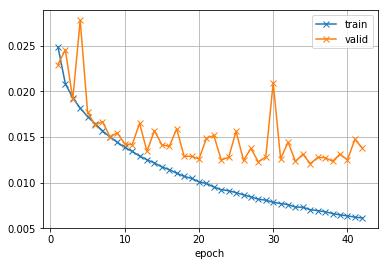

In [62]:
plt.plot(epochs, losses_train, '-x', label='train')
plt.plot(epochs, losses_valid, '-x', label='valid')
plt.xlabel('epoch')
plt.grid()
plt.legend()

In [57]:
del train_loader
# del valid_loader
# del model
del optimizer
del scheduler
del loss_func

gc.collect()

0

# save model

In [58]:
save_dir = f'{DIR_MODEL}/nb{NB}_{model.__class__.__name__}/'
file_dir = os.path.dirname(save_dir)
if not os.path.exists(file_dir):
    os.makedirs(file_dir)

In [59]:
save_path = f'{save_dir}model_{model.__class__.__name__}.pth'
save_path

'./../data_ignore/model/nb022_ResNet/model_ResNet.pth'

In [60]:
if DEBUG:
    pass
else:
    torch.save(model.state_dict(), save_path)

# check model

In [61]:
if DEBUG:
    pass
else:
    load_weights = torch.load(save_path)
    model.load_state_dict(load_weights)